# **Model Notebook for _Sign Language Recognition_ using _CNN_**

In [1]:
## Import Libraries

import pandas as pd

import tensorflow as tf

import numpy as np

import seaborn as sns
import cv2
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,Adagrad,Adadelta,Adamax,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import utils

import scipy
from scipy import stats
from scipy.stats import norm

from pathlib import Path
import os.path

import itertools

import skimage

import random

2024-03-04 09:01:36.504898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 09:01:36.505044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 09:01:36.667928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **Load Data**

In [2]:
## Defining directories for Test and Train Data

train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

### **Load Images**

In [3]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 29
train_len = 87000

# Create a dictionary to map folder names to labels
label_map = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21,
    'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28
}

def load_image(file_path):
    img = cv2.imread(file_path)
    if img is None:
        return None
    img = skimage.transform.resize(img, (imageSize, imageSize, 3))
    return img

def get_data(folder, label_map):
    X = []
    y = []
    
    for folderName in os.listdir(folder):
        if folderName not in label_map:
            continue  # Skip folders that are not in the mapping
        label = label_map[folderName]
        
        folder_path = os.path.join(folder, folderName)
        
        for image_filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_filename)
            img = load_image(image_path)
            
            if img is not None:
                X.append(img)
                y.append(label)
    
    return np.array(X), np.array(y)

X_train, y_train = get_data(train_dir, label_map)
print("Imported Images")

Imported Images


In [4]:
## Converting images and assigned labels into a Dataframe 

train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'Path':os.path.join(label_folder, f),'Label':folder} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
df = pd.DataFrame(all_data)
df

,Path,Label
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
...,...,...
86995,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J
86996,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J
86997,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J
86998,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J


### **Data Visualization**


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


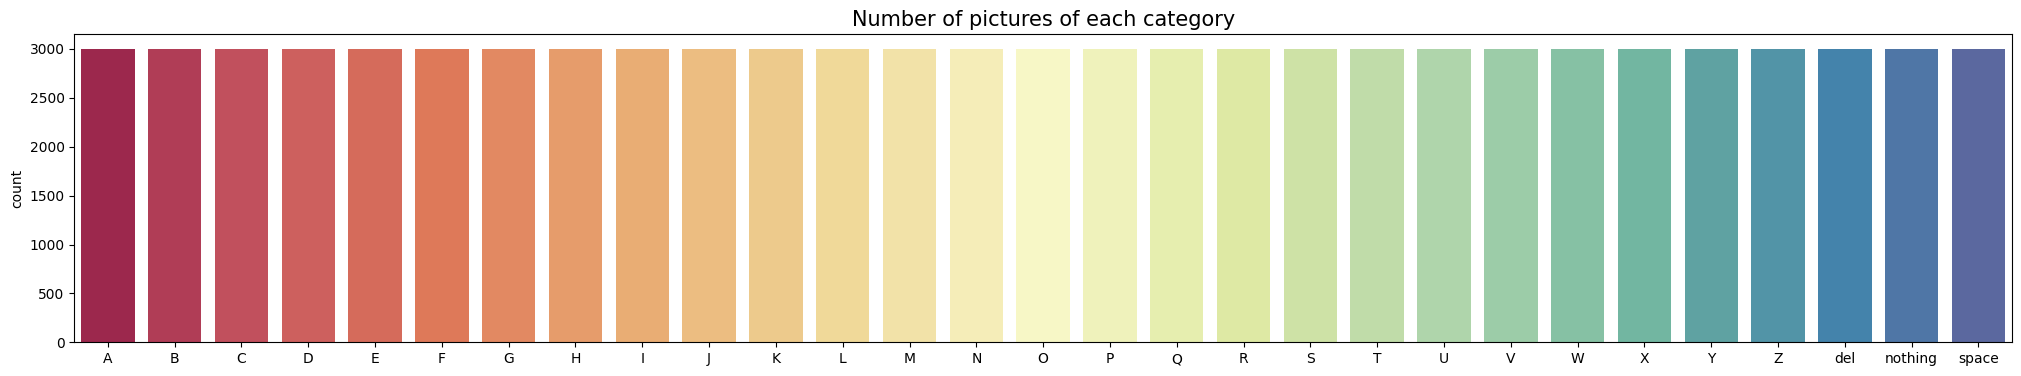

In [5]:
## Plotting count of images per each label

vc = df['Label'].value_counts()
plt.figure(figsize=(25,4))
sns.barplot(x = sorted(vc.index), y = vc,palette="Spectral")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

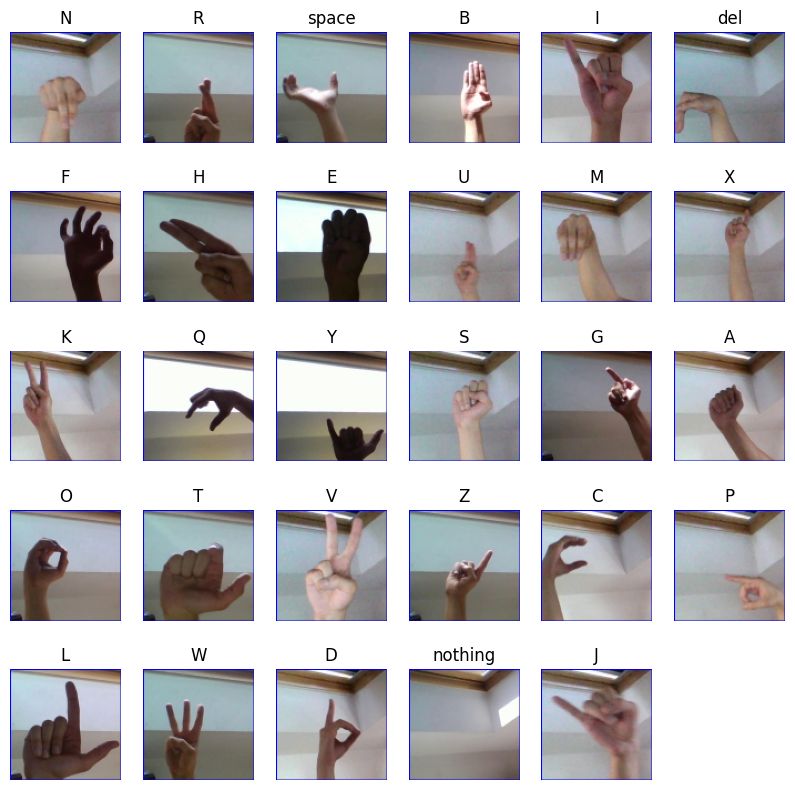

In [6]:
def load_and_display_unique_images():
    image_size = (100,100)
    unique_images = []  # List to store unique images
    unique_labels = []  # List to store corresponding labels

    # Iterate through the folders in the training directory
    for folder in os.listdir(train_dir):
        for file in os.listdir(os.path.join(train_dir, folder)):
            file_path = os.path.join(train_dir, folder, file)
            image = cv2.imread(file_path)
            final_image = cv2.resize(image, image_size)
            final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
            
            # Append the unique image and its label
            unique_images.append(final_image)
            unique_labels.append(folder)
            break  # Only load one image per category

    return unique_images, unique_labels

# Load unique images and their labels
unique_images, unique_labels = load_and_display_unique_images()

# Display the unique images and their labels in a grid
fig = plt.figure(figsize=(10,10))
def plot_image(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)

image_index = 0
rows, cols = 5, 6
for i in range(1, (rows * cols)):
    plot_image(fig, unique_images[image_index], unique_labels[image_index], rows, cols, i)
    image_index += 1

plt.show()

### **Data Pre-Processing**

In [7]:
"Creating new variables to avoid data mutation and maintaining code clarity"

X_data = X_train
y_data = y_train

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [10]:
from tensorflow.keras.utils import to_categorical

In [11]:
# One-Hot-Encoding the categorical data

y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)

In [12]:
print(X_train.shape)
print(y_train.shape)  
print(X_test.shape)   
print(y_test.shape)   
print(y_cat_train.shape)
print(y_cat_test.shape)   

(60900, 64, 64, 3)
(60900,)
(26100, 64, 64, 3)
(26100,)
(60900, 29)
(26100, 29)


In [13]:
# Garbage Collector (gc) is responsible for cleaning up and freeing memory that is no longer in use
import gc
del X_data
del y_data
gc.collect()
# This practice helps prevent memory-related errors and keeps your code running smoothly.

9118

### **Define Neural Network (CNN)**

In [14]:
model = Sequential()  # Create a sequential model

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))  # 32 filters, filter size (3, 3), input shape (64, 64, 3)
model.add(BatchNormalization())  # Apply batch normalization
model.add(Activation('relu'))  # Apply ReLU activation
model.add(MaxPooling2D((2, 2)))  # Apply max pooling with pool size (2, 2)

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3)))  # 64 filters, filter size (3, 3)
model.add(BatchNormalization())  # Apply batch normalization
model.add(Activation('relu'))  # Apply ReLU activation
model.add(MaxPooling2D((2, 2)))  # Apply max pooling with pool size (2, 2)

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3)))  # 128 filters, filter size (3, 3)
model.add(BatchNormalization())  # Apply batch normalization
model.add(Activation('relu'))  # Apply ReLU activation
model.add(MaxPooling2D((2, 2)))  # Apply max pooling with pool size (2, 2)

model.add(Flatten())  # Flatten the output from the convolutional layers

# Fully Connected Layer 1
model.add(Dense(256, activation='relu'))  # Dense layer with 256 units and ReLU activation
model.add(Dropout(0.5))  # Apply dropout with a rate of 0.5 to reduce overfitting

# Fully Connected Layer 2 (Output Layer)
model.add(Dense(29, activation='softmax'))  # Output layer with 29 units (for 29 classes) and softmax activation

model.summary()  # Display a summary of the model's architecture

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,501 (4.89 MB)

 Trainable params: 1,281,053 (4.89 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [16]:
# Compile the model with the defined optimizer, loss function, and evaluation metrics.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### **Model Fitting and Training**

In [17]:
early_stop = EarlyStopping(monitor='val_loss')

history = model.fit(X_train, y_cat_train, epochs=20, batch_size=32,validation_data=(X_test, y_cat_test))

Epoch 1/20
  14/1904 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0351 - loss: 0.5302 

I0000 00:00:1709543785.420809      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709543785.443468      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2744 - loss: 0.1446

W0000 00:00:1709543800.491761      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709543804.369572      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.2745 - loss: 0.1446 - val_accuracy: 0.7389 - val_loss: 0.0532
Epoch 2/20
  28/1904 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6752 - loss: 0.0607

W0000 00:00:1709543807.165443      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7547 - loss: 0.0481 - val_accuracy: 0.8907 - val_loss: 0.0301
Epoch 3/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8669 - loss: 0.0303 - val_accuracy: 0.9290 - val_loss: 0.0263
Epoch 4/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9220 - loss: 0.0209 - val_accuracy: 0.8546 - val_loss: 0.0560
Epoch 5/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9456 - loss: 0.0164 - val_accuracy: 0.9454 - val_loss: 0.0218
Epoch 6/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9587 - loss: 0.0131 - val_accuracy: 0.9342 - val_loss: 0.0272
Epoch 7/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9694 - loss: 0.0107 - val_accuracy: 0.9897 - val_loss: 0.0068
Epoch 8/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9736 - loss: 0.0098 - val_accuracy: 0.9943 - val_loss: 0.0046
Epoch 9/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9793 - loss: 0.0081 - val

In [18]:
metrics = pd.DataFrame(model.history.history)
print("The model metrics are")
metrics

The model metrics are


,accuracy,loss,val_accuracy,val_loss
0,0.455074,0.099320,0.738851,0.053153
1,0.791478,0.042250,0.890651,0.030139
2,0.884187,0.027353,0.928966,0.026295
3,0.928801,0.019526,0.854598,0.055964
4,0.949031,0.015291,0.945364,0.021760
5,0.962939,0.012255,0.934215,0.027178
6,0.971117,0.010226,0.989655,0.006787
7,0.975780,0.009125,0.994330,0.004584
8,0.981117,0.007570,0.977548,0.012225
9,0.983875,0.006887,0.996590,0.004105


### **Accuracy and Loss**

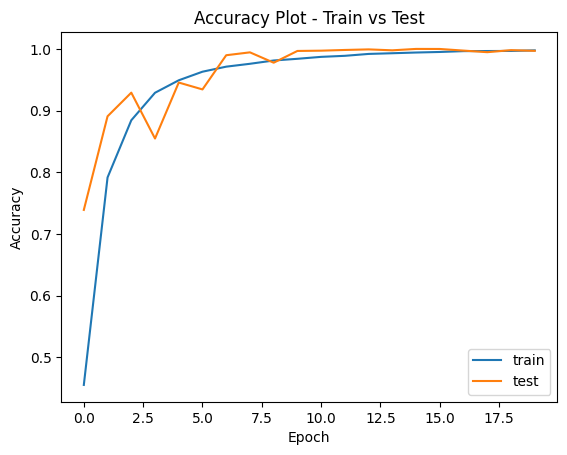

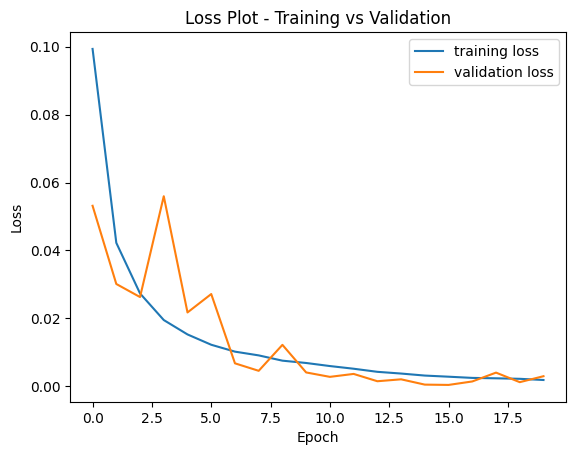

In [19]:
plt.plot(metrics['accuracy'])  # Plot training accuracy
plt.plot(metrics['val_accuracy'])  # Plot testing accuracy
plt.legend(['train', 'test'], loc='lower right')
plt.title('Accuracy Plot - Train vs Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plotting training and validation loss
plt.plot(metrics['loss'])  # Plots training loss
plt.plot(metrics['val_loss'])  # Plots validation loss
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.title('Loss Plot - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### **Model Evaluation**

In [20]:
# Model Evaluation
evaluate_metrics = model.evaluate(X_test,y_cat_test,verbose=0)

# Print the evaluation results
print("Evaluation Accuracy = {:.2f}%".format(evaluate_metrics[1] * 100))
print("Evaluation Loss = {:.6f}".format(evaluate_metrics[0]))

Evaluation Accuracy = 99.68%
Evaluation Loss = 0.002996


### **Classification Report**

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [22]:
# PREDICTION
predictions = model.predict(X_test)

# Since our output layer uses softmax activation, the predictions are probabilities for each class.
# To get the predicted class, find the index of the highest probability for each image.
predicted_classes = np.argmax(predictions, axis=1)

# Now, we can compare predicted classes with the actual classes (y_test) to evaluate the model's performance.
# Print the classification report and confusion matrix to assess the model's accuracy.
result=classification_report(np.argmax(y_cat_test, axis=1), predicted_classes)
print(result)

 84/816 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

W0000 00:00:1709544066.215393      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


816/816 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


W0000 00:00:1709544068.094367      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       900
           1       1.00      0.98      0.99       900
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       900
           4       0.97      1.00      0.98       900
           5       1.00      1.00      1.00       900
           6       1.00      1.00      1.00       900
           7       1.00      1.00      1.00       900
           8       1.00      0.99      1.00       900
           9       1.00      1.00      1.00       900
          10       1.00      1.00      1.00       900
          11       1.00      1.00      1.00       900
          12       0.98      1.00      0.99       900
          13       1.00      0.99      0.99       900
          14       1.00      1.00      1.00       900
          15       0.99      1.00      1.00       900
          16       1.00      0.99      1.00       900
          17       1.00    

### **Confusion Matrix**

<Axes: >

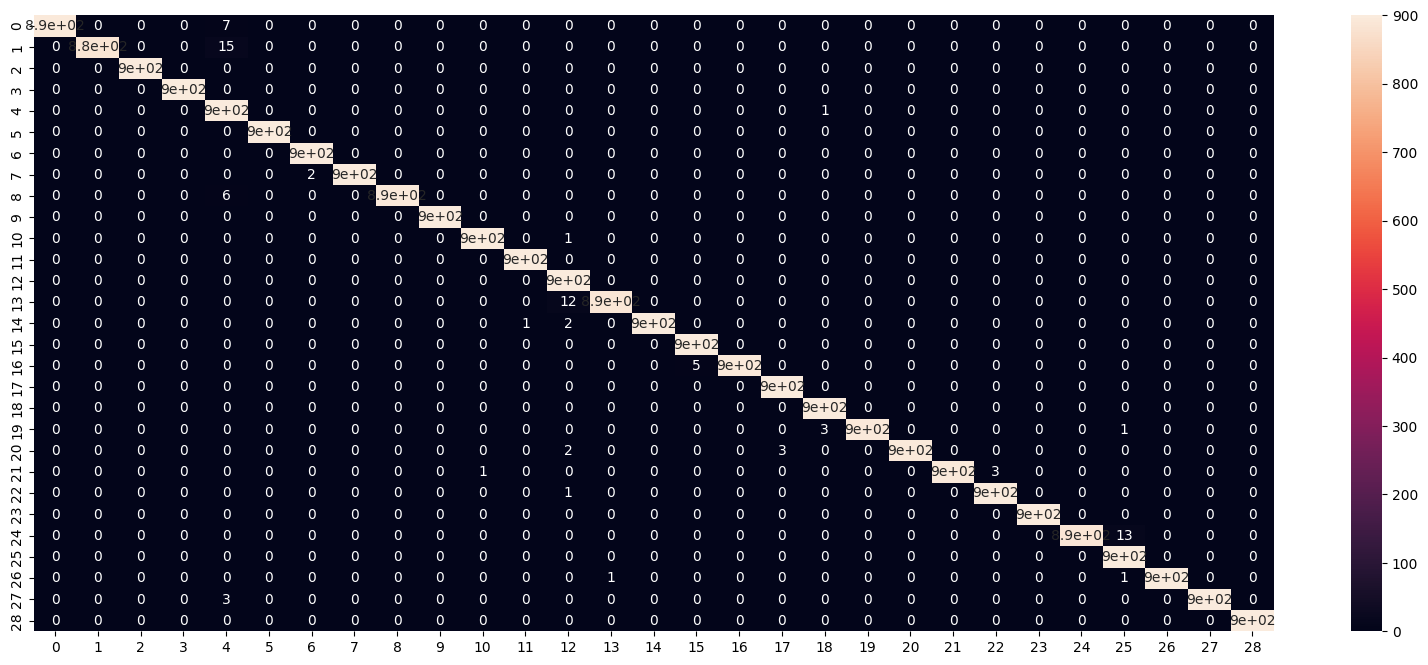

In [23]:
results=confusion_matrix(np.argmax(y_cat_test, axis=1), predicted_classes)
import seaborn as sns
plt.figure(figsize=(20,8))
sns.heatmap(results,annot=True)

### **Prediction**

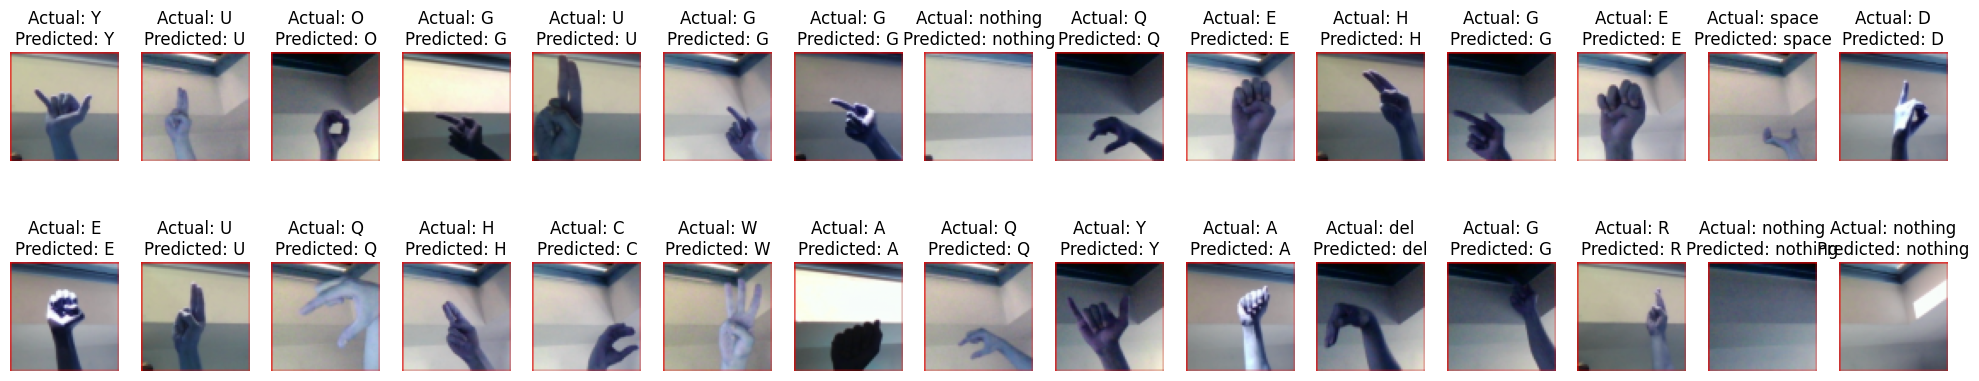

In [24]:
num_samples = 30  # We can change this to the number of samples we want to visualize.
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
          'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
          'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


plt.figure(figsize=(25,5))
for i in range(num_samples):
    index = random.randint(0, len(X_test) - 1)
    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {labels[y_test[index]]}\nPredicted: {labels[predicted_classes[index]]}")
    plt.axis('off')

plt.show()

In [25]:
## SAVE THE MODEL 

from keras.models import load_model
model.save('Sign_Recognition.h5')